# Imports/Setup

The cell below provides imports all the libraries and packages needed to run this notebook. Additionally, it defines a number of global variables used repeatedly throughout. 

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit.primitives import StatevectorSampler, Sampler
from qiskit_machine_learning.algorithms import QSVC, PegasosQSVC
from qiskit_aer import Aer


from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.utils import algorithm_globals

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, confusion_matrix, precision_score, recall_score
from sklearn.inspection import permutation_importance

from scipy.stats import shapiro, normaltest, boxcox, spearmanr, kendalltau
from scipy.special import boxcox1p

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier


fig_count = 0
# !rm ../documents/figures/fig*

figsize_x = 6
figsize_y = 6

algorithm_globals.random_seed = 19
rs = 19

sig = 0.05

# Import Data

The cell below reads in the data:

In [2]:
df = pd.read_csv('../data/creditcard_2023.csv', usecols=lambda column: column != 'id')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


# Dataset Summary

Provide a summary of the data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      568630 non-null  float64
 1   V2      568630 non-null  float64
 2   V3      568630 non-null  float64
 3   V4      568630 non-null  float64
 4   V5      568630 non-null  float64
 5   V6      568630 non-null  float64
 6   V7      568630 non-null  float64
 7   V8      568630 non-null  float64
 8   V9      568630 non-null  float64
 9   V10     568630 non-null  float64
 10  V11     568630 non-null  float64
 11  V12     568630 non-null  float64
 12  V13     568630 non-null  float64
 13  V14     568630 non-null  float64
 14  V15     568630 non-null  float64
 15  V16     568630 non-null  float64
 16  V17     568630 non-null  float64
 17  V18     568630 non-null  float64
 18  V19     568630 non-null  float64
 19  V20     568630 non-null  float64
 20  V21     568630 non-null  float64
 21  V22     56

The output elucidates that `df` contains 568,630 observations of 29 predictor variables (`V1`-`V28`, and `Class`) and one target variable, `Class`.

# Data Evaluation
## Class Imbalance

The cell below compares the observations in each class using histograms:

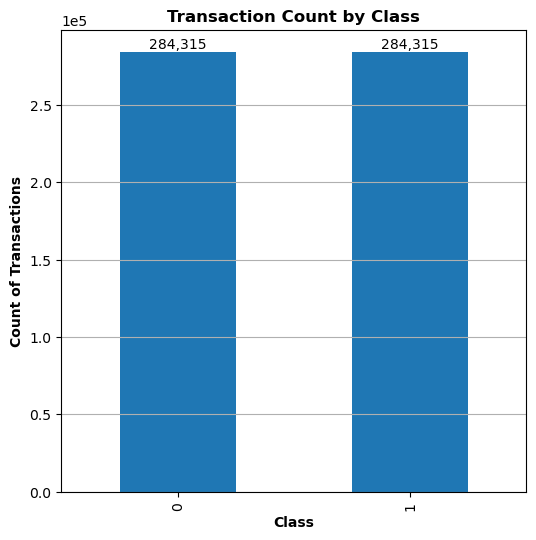

In [4]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

class_counts = df['Class'].value_counts()

class_counts.plot(kind='bar')  # or use 'hist' for a histogram

for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.1, f'{value:,}', ha='center', va='bottom')
    
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Count of Transactions',fontweight='bold')
plt.title('Transaction Count by Class', fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(axis='y')
plt.savefig(f'../documents/figures/fig_1.png')
plt.show()

To make the dataset more realistic, the cell below drops drop positive (A.K.A fraudulent, 1) observations until they only make up 1% of the entire dataset. Removals are done at random.

In [5]:
# fraud_prop = 0.01
# fraud_size = int((fraud_prop * class_counts[0]) / (1 - fraud_prop))
# num_removals = class_counts[1] - fraud_size

# condition = df['Class'] == 1
# rows_to_remove = df[condition].sample(n=num_removals, random_state=rs)
# df = df.drop(rows_to_remove.index)

In [6]:
n = 10000
fraud_prop = 0.01
fraud_size = int(n * fraud_prop)
true_size = int(n * (1-fraud_prop))

df_pt1 = df[df['Class'] == 1].sample(n=fraud_size, random_state=rs)
df_pt2 = df[df['Class'] == 0].sample(n=true_size, random_state=rs)

df = pd.concat([df_pt1, df_pt2], ignore_index=True)

The plot below checks to ensure an appropriate number of observations have been removed:

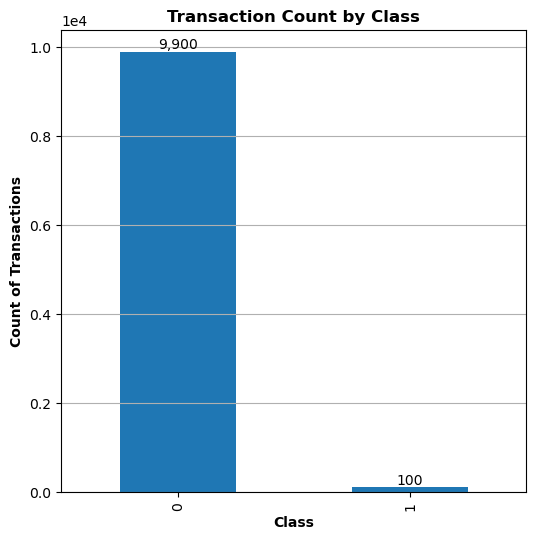

In [7]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

class_counts = df['Class'].value_counts()

class_counts.plot(kind='bar')  # or use 'hist' for a histogram

for i, value in enumerate(class_counts.values):
    plt.text(i, value + 0.1, f'{value:,}', ha='center', va='bottom')
    
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Count of Transactions',fontweight='bold')
plt.title('Transaction Count by Class', fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(axis='y')
plt.savefig(f'../documents/figures/fig_2.png')
plt.show()

Before moving onto the next section, the cell below splits `df` into two new dataframes: 

* `df_X`: Contains only the predictors present in `df`.
* `df_y`: Contains only the target variable in `df`: `Class`.

In [8]:
df_X = df.drop(['Class'], axis=1)
df_y = df['Class']

## Outliers

Evaluating the presence of outliers is crucial to deciding the data pre-processing steps required for modelling. The cell below creates function that identifies the outliers in each column of a dataframe. 

In [9]:
def identify_outliers(df):
    outlier_rows = []
    for column in df.select_dtypes(include='number'):  # Only process numeric columns
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        for i, value in enumerate(df[column].values):
            if value < lower_bound or value > upper_bound:
                outlier_rows.append([column, i, value])
            
    # Get unique rows with at least one outlier
    return pd.DataFrame(outlier_rows, columns = ['column_name', 'row_num', 'value'])

The `identify_outliers` function is used below to identify all outliers in `df`:

In [10]:
outlier_df = identify_outliers(df_X)
outlier_df = (
    outlier_df[['column_name', 'row_num']]
    .groupby(by='column_name').count()
    .sort_values(by='row_num')
    .reset_index()
)
outlier_df.columns = ['column_name', 'num_outliers']

The data contained within `outlier_df` is presented in the plot below:

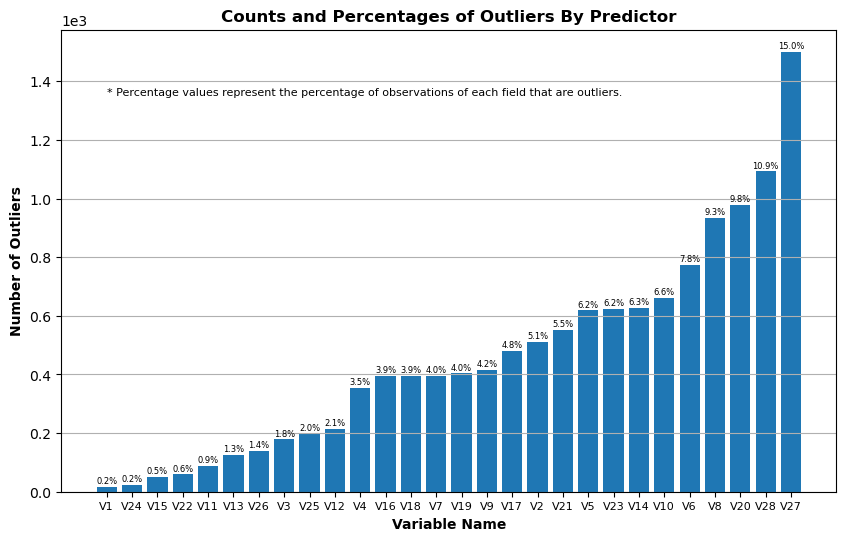

In [11]:
fig_count += 1
plt.figure(figsize=(10,6))

plt.bar(outlier_df['column_name'], outlier_df['num_outliers'])
label_push = outlier_df['num_outliers'].mean() * 0.01

for i, value in enumerate(outlier_df['num_outliers'].values):
    
    perc_outlier = (value / df.shape[0]) * 100
    plt.text(i, value + label_push, f'{perc_outlier:.1f}%', ha='center', va='bottom', fontsize=6)
    
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Number of Outliers',fontweight='bold')
plt.title('Counts and Percentages of Outliers By Predictor', fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

label_height = outlier_df['num_outliers'].max() * .90
plt.text(0, label_height, '* Percentage values represent the percentage of observations of each field that are outliers.', fontsize=8)

plt.grid(axis='y')
plt.savefig(f'../documents/figures/fig_3.png')
plt.show()

Clearly, the dataframe contains a reasonable number of outliers in many of the fields. This will be one of the primary considerations when choosing the data pre-processing steps in the next section. 

## Distributions

The shape of the distributions of each predictor is another consideration when determining the appropriate data pre-processing steps. They are plotted below using a boxplot:

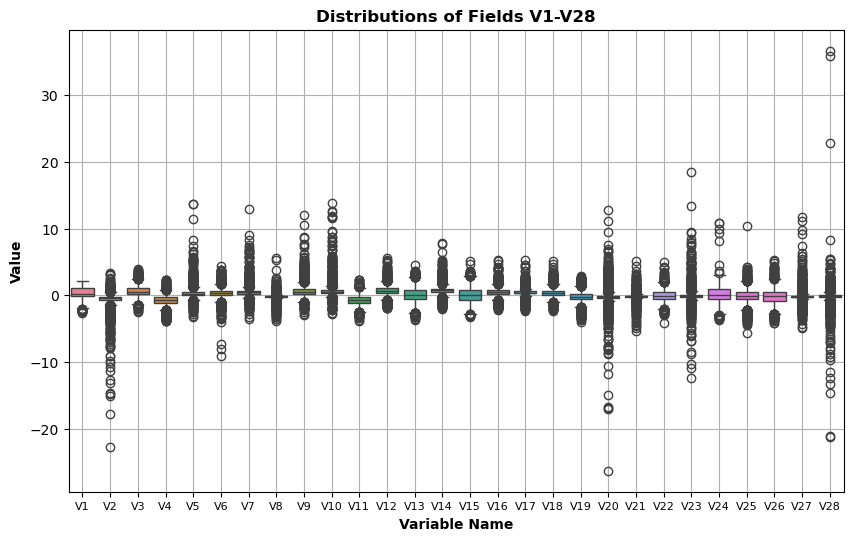

In [12]:
fig_count += 1
plt.figure(figsize=(10,6))
plt_df = df.drop(['Class', 'Amount'], axis=1)

sns.boxplot(data=plt_df)
plt.grid()
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Distributions of Fields V1-V28', fontweight='bold')
plt.tick_params(axis='x', which='major', labelsize=8)
plt.savefig(f'../documents/figures/fig_5.png')
plt.show()

The many outliers make the distributions hard to see, but they can also be evaluated quantitatively to determine their shape. For instance, the cell below defines a function `evaluate_normality` that determines if each predictor variable exhibits a normal distribution using `scipy`'s `normaltest`:

In [13]:
def evaluate_normality(df):
    results = []
    for column in df.columns:
        stat, p = normaltest(df[column])
        normal = p > 0.05
        results.append([column, stat, p, normal])
                       

    return pd.DataFrame(results, columns = ['variable_name', 'statistic', 'p_value', 'normal'])

In [14]:
evaluate_normality(df_X)

,variable_name,statistic,p_value,normal
0,V1,1418.985402,7.434211e-309,False
1,V2,15608.543484,0.000000e+00,False
2,V3,807.761624,3.951772e-176,False
3,V4,644.347399,1.207091e-140,False
4,V5,10552.980813,0.000000e+00,False
5,V6,1770.853679,0.000000e+00,False
6,V7,11997.946103,0.000000e+00,False
7,V8,3911.609600,0.000000e+00,False
8,V9,5571.030988,0.000000e+00,False
9,V10,13333.634549,0.000000e+00,False


The output above makes clear that none of the predictor variables can be considered to have a normal distribution. 

## Multicollinearity

The last aspect of the data taken into consideration before apply any pre-processing transformation is its multicollinearity. The cell below produces a correlation matrix of all the predictor fields, which checks the correlation of all pairs of predictors.

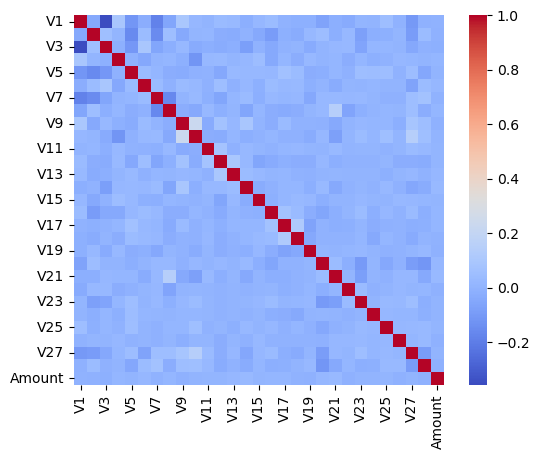

V9


In [15]:
correlation_matrix = df_X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", square=True)
plt.savefig(f'../documents/figures/fig_4.png')
plt.show()
print(max(correlation_matrix))

The minimum and maximum correlation values are also displayed below: 

In [16]:
correlation_matrix = correlation_matrix.replace(1, 0)

max_corr_value = correlation_matrix.select_dtypes(include='number').max().max()
min_corr_value = correlation_matrix.select_dtypes(include='number').min().min()

print(f'Minimum correlation value: {min_corr_value}')
print(f'Maximum correlation value: {max_corr_value}')

Minimum correlation value: -0.3571642953929529
Maximum correlation value: 0.23125023710858614


The output above coupled with the results of the correlation matrix provide strong evidence that no pair of predictor variables maintain a troublesome degree of correlation. 

# Data Pre-Processing

Based on the results of the previous section, there are two facets of the data that need to be addressed:

1. A large number of outliers present within many predictors.
2. Non-normal distributions for all predictors. 

There is no reason to believe the outliers are due to error, and should likely continue to be included in the dataset. However, given their quantity and scale, these outliers can have their influence limited by applying Winsorization, in which outliers are "pulled in" by capping extreme values to a specified percentile range. 

To address the non-normal (skewed) distributions of the predictors, we can perform a power transformation that will have the effect of smoothing the variance over the range of the distribution (reducing heteroscedasticity). This kind of transformation typically supports normalization. Box-Cox and Yeo-Johnson transformations are the most common approaches, but the latter will be applied in this case since the former only works for values $>0$. 

To prevent data leakage, these transformations will be fitted exclusively on a training dataset, and the resultant parameters will then be applied to transform the data.

First the cell below splits the data into testing and training matrices:

In [17]:
X = df_X.values
y = df_y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=rs)

Next, the cell below defines a function that can apply the windsorization transformation:

In [18]:
def apply_winsorization(train_matrix, test_matrix, limits=(0.05, 0.95)):
    """
    Apply Winsorization to all columns in training and test matrices.

    Args:
        train_matrix (np.ndarray): Training data matrix.
        test_matrix (np.ndarray): Test data matrix.
        limits (tuple): Quantile limits for Winsorization (default is (0.05, 0.95)).

    Returns:
        np.ndarray, np.ndarray: Transformed training and test matrices.
    """
    train_matrix = train_matrix.copy()
    test_matrix = test_matrix.copy()

    for col in range(train_matrix.shape[1]):  # Loop over all columns
        lower, upper = np.quantile(train_matrix[:, col], limits)
        train_matrix[:, col] = np.clip(train_matrix[:, col], lower, upper)
        test_matrix[:, col] = np.clip(test_matrix[:, col], lower, upper)
    
    return train_matrix, test_matrix

The training and testing data are transformed below using the `apply_windsorization` function:

In [19]:
X_train, X_test = apply_winsorization(X_train, X_test)

Next, the cell below applies the Yeo-Johnson transformation:

In [20]:
yj = PowerTransformer(method='yeo-johnson')

X_train = yj.fit_transform(X_train)
X_test = yj.transform(X_test)

The final pre-processing step is to scale the data appropriately. Given that the data was not originally considered normal, standard scaling (in which $\mu$=0 and $\sigma=1$ is not appropriate. Furthermore, min-max scaling (in which all fields are scaled to be between 0 and 1) is sensitive to outliers, which excludes it as a choice in this case. Robust scaling is a common choice when dealing with data with outliers, since it works by centering the data it each field around its median value and then scaling according to its IQR. As such, this was the scaling option implemented: 

In [21]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
df_X_pp = pd.DataFrame(np.vstack((X_train, X_test)), columns=df_X.columns)
df_y_pp = pd.Series(np.concatenate([y_train, y_test]), name=df_y.name)
df_pp = pd.concat([df_X_pp, df_y_pp], axis=1)

The result of the scaling is shown in the following plot: 

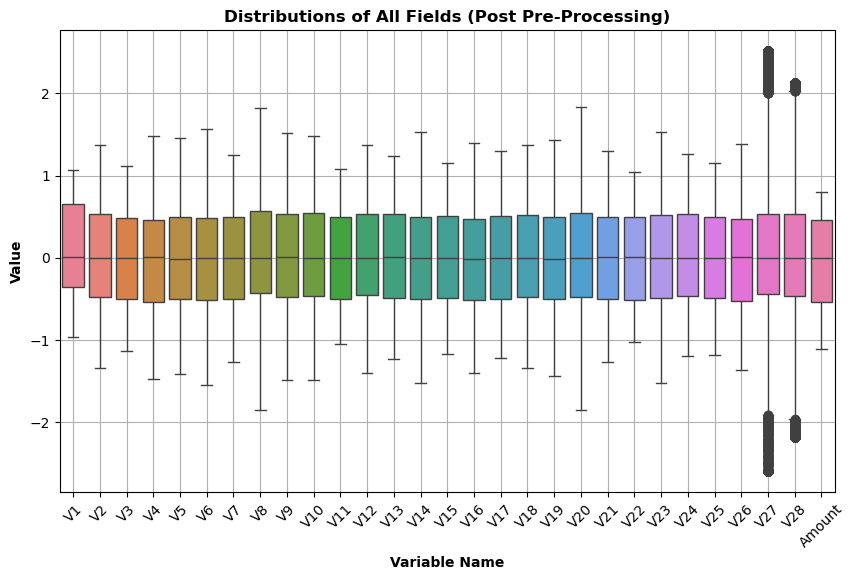

In [23]:
fig_count += 1

plt.figure(figsize=(10,6))

sns.boxplot(data=df_X_pp)
plt.grid()
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.title('Distributions of All Fields (Post Pre-Processing)', fontweight='bold')
plt.xticks(rotation=45)
plt.savefig(f'../documents/figures/fig_6.png')
plt.show()

It is clear that the result of the pre-processing steps resulted in a significantly more interpretable dataset. The ranges of each field are similar and outliers now only exist in two (instead of all) fields: 

In [24]:
outlier_df = identify_outliers(df_X_pp)
outlier_df = (
    outlier_df[['column_name', 'row_num']]
    .groupby(by='column_name').count()
    .sort_values(by='row_num')
    .reset_index()
)
outlier_df.columns = ['column_name', 'num_outliers']
outlier_df

,column_name,num_outliers
0,V28,1142
1,V27,1475


Unfortunately, the data is still not considered to be normal, meaning that further pre-processing transformations such as PCA would likely not be as effective. However, multicollinearity was deemed earlier not to be a significant concern in this dataset, meaning there is not likely a great need for dimensionality reduction regardless. 

In [25]:
evaluate_normality(df_X_pp)

,variable_name,statistic,p_value,normal
0,V1,22360.193687,0.000000e+00,False
1,V2,298.345378,1.641060e-65,False
2,V3,1531.804584,0.000000e+00,False
3,V4,176.540437,4.620949e-39,False
4,V5,273.190784,4.757459e-60,False
5,V6,108.405710,2.884026e-24,False
6,V7,687.088797,6.317766e-150,False
7,V8,1.046222,5.926737e-01,True
8,V9,224.688511,1.619980e-49,False
9,V10,217.805346,5.060228e-48,False


# Exploratory Data Analysis

The cell below evaluates which predictors might be most important to the model by performing $t$-tests of the means of each predictor variable separated by class. 

In [26]:
df_class0 = df_pp[df_pp['Class'] == 0]
df_class1 = df_pp[df_pp['Class'] == 1]

p_vals = []
for col in df_X.columns:
    
    group1 = df_class0[col]
    group2 = df_class1[col]
    
    t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False)
    
    p_vals.append(p_value)

The results of these t-tests can be visualized below:

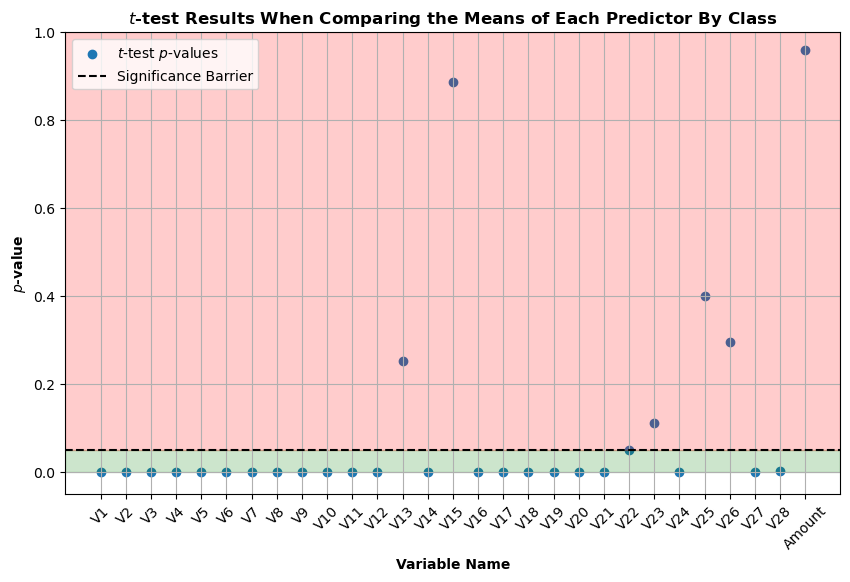

In [27]:
fig_count += 1
plt.figure(figsize=(10, figsize_y))

xs = np.arange(0,len(p_vals))
plt.scatter(xs, p_vals, label='$t$-test $p$-values')
plt.axhline(sig, color='black', ls='--', label='Significance Barrier')
plt.axhspan(0, sig, color='green', alpha=0.2)
plt.axhspan(sig, 1, color='red', alpha=0.2)
plt.xticks(xs, df_X.columns)
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('$p$-value', fontweight='bold')
plt.title('$t$-test Results When Comparing the Means of Each Predictor By Class', fontweight='bold')
plt.ylim(-0.05,1)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig(f'../documents/figures/fig_7.png')
plt.show()

Most of the variables exhibit statistically significant differences when comparing the means of the observations in each class. The cells below provide histograms of two of these predictors as examples, highlighting the difference in distribution when split by class. 

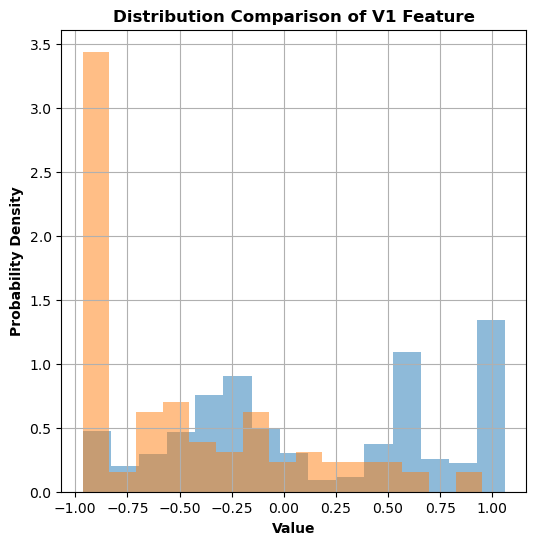

In [28]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

group1 = df_class0['V1']
group2 = df_class1['V1']

plt.hist(group1, bins=15, alpha=0.5, density=True, label='Class 0')
plt.hist(group2, bins=15, alpha=0.5, density=True, label='Class 1')

plt.title('Distribution Comparison of V1 Feature', fontweight='bold')
plt.grid()
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Probability Density', fontweight='bold')
plt.savefig(f'../documents/figures/fig_8.png')
plt.show()

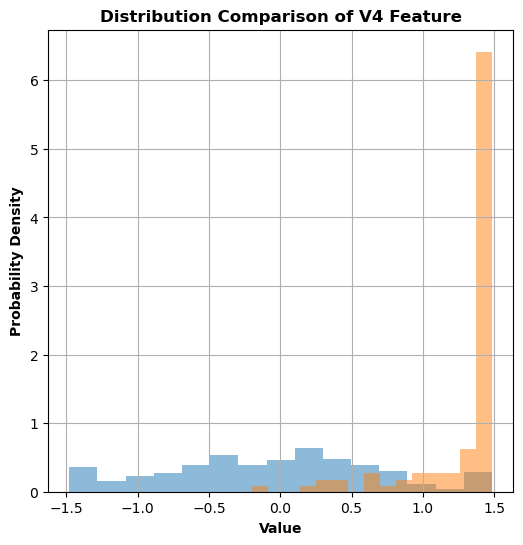

In [29]:
fig_count += 1
plt.figure(figsize=(figsize_x, figsize_y))

group1 = df_class0['V4']
group2 = df_class1['V4']

plt.hist(group1, bins=15, alpha=0.5, density=True, label='Class 0')
plt.hist(group2, bins=15, alpha=0.5, density=True, label='Class 1')

plt.title('Distribution Comparison of V4 Feature', fontweight='bold')
plt.grid()
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Probability Density', fontweight='bold')
plt.show()

## PCA

In [30]:
pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components_to_keep = np.argmax(cumulative_variance >= 0.95) + 1

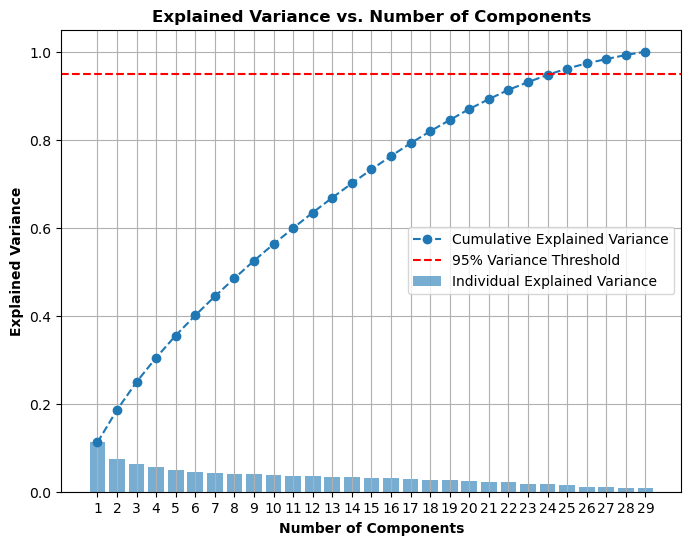

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual Explained Variance')

plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title('Explained Variance vs. Number of Components', fontweight='bold')
plt.xlabel('Number of Components', fontweight='bold')
plt.ylabel('Explained Variance', fontweight='bold')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend(loc='best')
plt.grid()
plt.show()

In [32]:
# pca = PCA(n_components = n_components_to_keep)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

In [33]:
# fig_count += 1
# plt.figure(figsize=(figsize_x, figsize_y))

# class_counts = pd.Series(y_train).value_counts()

# class_counts.plot(kind='bar')  # or use 'hist' for a histogram

# for i, value in enumerate(class_counts.values):
#     plt.text(i, value + 0.1, f'{value:,}', ha='center', va='bottom')
    
# plt.xlabel('Class', fontweight='bold')
# plt.ylabel('Count of Transactions',fontweight='bold')
# plt.title('Transaction Count by Class', fontweight='bold')
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.grid(axis='y')
# #plt.savefig(f'../documents/figures/fig_{fig_count}.png')
# plt.show()

# Classical Machine Learning 
## SVM


In [34]:
svm = SVC(class_weight='balanced', random_state=rs) 

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Perform grid search
scoring_fcn = make_scorer(f1_score, pos_label=1)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring=scoring_fcn, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters and evaluate on the test set
print("Best Parameters:", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.5s
[CV] END .......................C=0.1, gamma=0.1

In [35]:
result = permutation_importance(best_svm_model, X_test, y_test, n_repeats=10)
importances = result.importances_mean
importance_df_svm = pd.DataFrame({'variable_name': df_X_pp.columns, 'permutation_importance': importances})
importance_df_svm = importance_df_svm.sort_values(by='permutation_importance', ascending=False).reset_index()

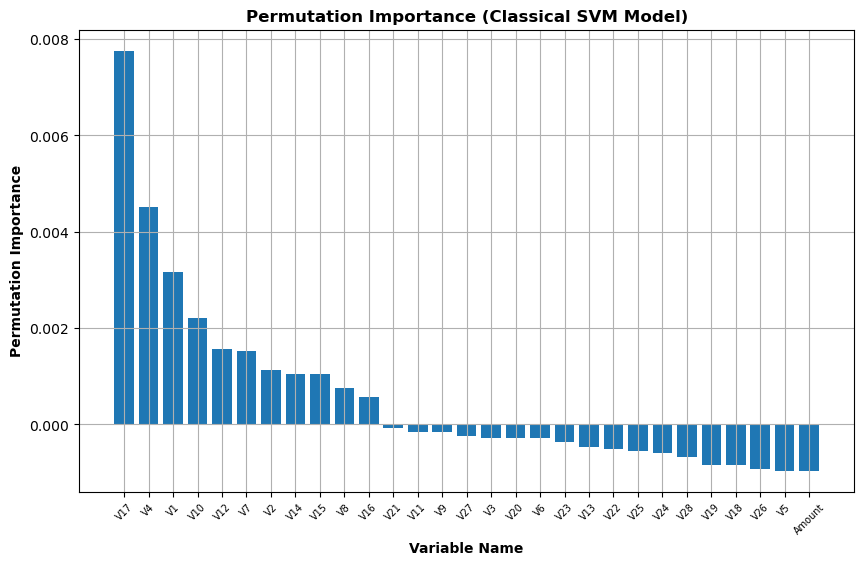

In [36]:
fig_count += 1
plt.figure(figsize=(10,figsize_y))

plt.bar(importance_df_svm['variable_name'], importance_df_svm['permutation_importance'])

plt.title('Permutation Importance (Classical SVM Model)', fontweight='bold')
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Permutation Importance', fontweight='bold')
plt.xticks(rotation=45, fontsize = 7)

plt.grid()
plt.savefig(f'../documents/figures/fig_9.png')
plt.show()

## Random Forest

In [37]:
rf = RandomForestClassifier(class_weight='balanced', random_state=rs)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=scoring_fcn, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters and evaluate on the test set
print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_

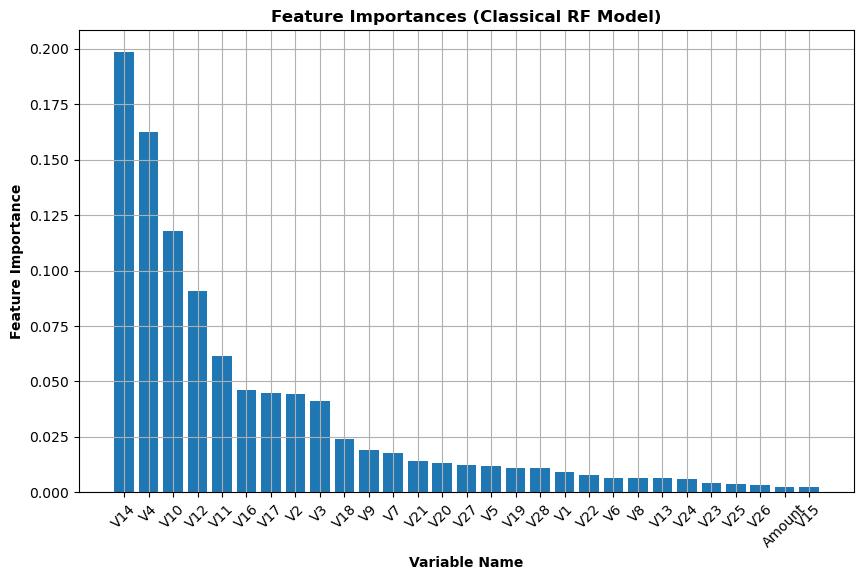

In [38]:
fig_count += 1
feature_importances = best_rf_model.feature_importances_

importance_df_rf = pd.DataFrame({'variable_name': df_X_pp.columns, 'feature_importance': feature_importances})
importance_df_rf = importance_df_rf.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, figsize_y))
plt.bar(importance_df_rf['variable_name'], importance_df_rf['feature_importance'])
plt.title('Feature Importances (Classical RF Model)', fontweight='bold')
plt.xlabel('Variable Name', fontweight='bold')
plt.ylabel('Feature Importance', fontweight='bold')
plt.xticks(rotation=45)
plt.grid()
plt.savefig(f'../documents/figures/fig_10.png')
plt.show()

In [39]:
feature_ranks = []

for column in df_X_pp.columns:
    rank_rf = importance_df_rf[importance_df_rf['variable_name'] == column].index.item()
    rank_svm = importance_df_svm[importance_df_svm['variable_name'] == column].index.item()
    feature_ranks.append([column, rank_rf, rank_svm])

feature_ranks_df = pd.DataFrame(feature_ranks, columns=['variable_name', 'rf_importance', 'svm_importance'])
rho, p_val = spearmanr(feature_ranks_df['rf_importance'], feature_ranks_df['svm_importance'])
tau, p_val = kendalltau(feature_ranks_df['rf_importance'], feature_ranks_df['svm_importance'])
rho

0.5926108374384236

# Quantum Algorithm Evaluation
## Data Prep

In [40]:
# n = 1000
# fraud_prop = 0.10
# fraud_size = int(n * fraud_prop)
# true_size = int(n * (1-fraud_prop))

# q_df_pt1 = df_pp[df_pp['Class'] == 1].sample(n=fraud_size, random_state=rs)
# q_df_pt2 = df_pp[df_pp['Class'] == 0].sample(n=true_size, random_state=rs)

# q_df = pd.concat([q_df_pt1, q_df_pt2], ignore_index=True)
# q_X = q_df.drop(columns='Class').values
# q_y = q_df['Class'].values

q_X_train, q_X_test, q_y_train, q_y_test = train_test_split(df_X_pp.values, df_y_pp.values,
                                                            stratify=y, test_size=0.25, random_state=rs)



smote = SMOTE(random_state=rs, k_neighbors=3)
q_X_train, q_y_train = smote.fit_resample(q_X_train, q_y_train)

q_train = pd.DataFrame(np.hstack((q_X_train, q_y_train.reshape(-1,1))), columns=df_pp.columns)
q_test = pd.DataFrame(np.hstack((q_X_test, q_y_test.reshape(-1,1))), columns=df_pp.columns)

n = 50
q_train_df_pt1 = q_train[q_train['Class'] == 1].sample(n=n, random_state=rs)
q_train_df_pt2 = q_train[q_train['Class'] == 0].sample(n=n, random_state=rs)

n = 25
q_test_df_pt1 = q_test[q_test['Class'] == 1].sample(n=n, random_state=rs)
q_test_df_pt2 = q_test[q_test['Class'] == 0].sample(n=n, random_state=rs)

q_train = pd.concat([q_train_df_pt1, q_train_df_pt2], ignore_index=True)
q_test = pd.concat([q_test_df_pt1, q_test_df_pt2], ignore_index=True)

q_X_train = q_train.drop(columns='Class').values
q_y_train = q_train['Class'].values
q_X_test = q_test.drop(columns='Class').values
q_y_test = q_test['Class'].values

## QSVM

In [41]:
num_qubits = 2

feature_names = importance_df_svm['variable_name'].values[:num_qubits]
feature_indices = df_X_pp.columns.get_indexer(feature_names)
X_train_tmp = q_X_train[:, feature_indices]
X_test_tmp = q_X_test[:, feature_indices]

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_tmp = scaler.fit_transform(X_train_tmp)
X_test_tmp = scaler.transform(X_test_tmp)

feature_map = ZZFeatureMap(feature_dimension=X_train_tmp.shape[1], reps=1, entanglement='linear')
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler, num_virtual_qubits=X_train_tmp.shape[1])
qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
embeddings = qkernel.evaluate(X_train_tmp, X_train_tmp)
qsvm = SVC()
qsvm.fit(embeddings, q_y_train)

SVC()

In [42]:
test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
y_pred = qsvm.predict(test_embeddings)
print(classification_report(q_y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84        25
         1.0       0.84      0.84      0.84        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



In [43]:
def fit_qsvm(X_train, y_train, reps, entanglement_type, rs):
    
    feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=reps, entanglement=entanglement_type)
    sampler = StatevectorSampler()
    fidelity = ComputeUncompute(sampler=sampler, num_virtual_qubits=X_train.shape[1])
    qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    q_start_time = time.time()
    embeddings = qkernel.evaluate(X_train, X_train)
    q_end_time = time.time()
    q_time = q_end_time - q_start_time


    qsvm = SVC(class_weight='balanced', random_state=rs)
    fit_start_time = time.time()
    qsvm.fit(embeddings, y_train)
    fit_end_time = time.time()
    fit_time = fit_end_time - fit_start_time
        
    return qsvm, qkernel, q_time, fit_time

In [44]:
qsvm, qkernel, q_time, fit_time = fit_qsvm(X_train_tmp, q_y_train, 1, 'linear', rs)
test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
y_pred = qsvm.predict(test_embeddings)
print(classification_report(q_y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84        25
         1.0       0.84      0.84      0.84        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



In [45]:
def evaluate_qsvm(qubits_range, entanglement_types, reps_range, importance_df, X_train, X_test, y_train, y_test, rs):

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    results = []
    for num_qubits in qubits_range:
            
        feature_names = importance_df['variable_name'].values[:num_qubits]
        feature_indices = df_X_pp.columns.get_indexer(feature_names)
        X_train_tmp = X_train[:, feature_indices]
        X_test_tmp = X_test[:, feature_indices]

        for entanglement_type in entanglement_types:
            for reps in reps_range:

                print('Running QSVM algorithm with the following parameters...')
                print(f'num_qubits={num_qubits}, entanglement_type={entanglement_type}, reps={reps}')
                
                start_time = time.time()

                qsvm, qkernel, q_time, fit_time = fit_qsvm(X_train_tmp, y_train, reps, entanglement_type, rs) 
                test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
                y_pred = qsvm.predict(test_embeddings)

                f1_class1 = f1_score(y_test, y_pred, pos_label=1)
                f1_class0 = f1_score(y_test, y_pred, pos_label=0)
                precision_class1 = precision_score(y_test, y_pred, pos_label=1)
                precision_class0 = precision_score(y_test, y_pred, pos_label=0)
                recall_class1 = recall_score(y_test, y_pred, pos_label=1)
                recall_class0 = recall_score(y_test, y_pred, pos_label=0)
                accuracy = accuracy_score(y_test, y_pred)
    
                results.append([num_qubits, entanglement_type, reps, q_time, fit_time, f1_class1, f1_class0, precision_class1,
                                precision_class0, recall_class1, recall_class0, accuracy])

                end_time = time.time()
                process_time = end_time - start_time
                print(f'Finished after {process_time}s')   

    column_names = ['num_qubits', 'entanglement_type', 'reps', 'q_time', 'fit_time',
                    'f1_class1', 'f1_class0', 'precision_class1', 'precision_class0',
                    'recall_class1', 'recall_class0', 'accuracy']
                
    return pd.DataFrame(results, columns=column_names)

In [46]:
qubits_range = list(range(2,10))
entanglement_types = ['linear', 'circular', 'full']
reps_range = [1,2,3]

# qsvm_results = evaluate_qsvm(qubits_range, 
#                              entanglement_types, 
#                              reps_range, 
#                              importance_df_svm, 
#                              q_X_train, q_X_test, q_y_train, q_y_test,
#                              rs)

excel_file = '../data/QML_Algorithm_Saved_Results.xlsx'
sheet_name = 'QSVM'

# with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
#     qsvm_results.to_excel(writer, sheet_name=sheet_name, index=False)

qsvm_results = pd.read_excel(excel_file, sheet_name=sheet_name)

In [47]:
def plot_qsvm_results(qsvm_results, x_name, y_name, iterable, iterable_name,
                      x_label, y_label, title, legend_title, ylim, fignum=None):
    
    plt.figure(figsize=(8,10))
    
    num_plots = len(entanglement_types)
    for i, entanglement_type in enumerate(entanglement_types):
        
        plt.subplot(num_plots, 1, i+1)
        for i in iterable:
            tmp = qsvm_results[(qsvm_results['entanglement_type'] == entanglement_type) & (qsvm_results[iterable_name] == i)]
            plt.plot(tmp[x_name], tmp[y_name], label= i)
        plt.legend(title=legend_title, loc='upper left')
        plt.title(f'Entanglement Type: {entanglement_type}', fontweight='bold')
        plt.xlabel(x_label, fontweight='bold')
        plt.ylabel(y_label, fontweight='bold')
        plt.ylim(0, ylim)
        plt.grid()
    
    plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing (default is usually 0.2)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    if fignum is not None:
        plt.savefig(f'../documents/figures/fig_{fignum}.png')
    plt.show()

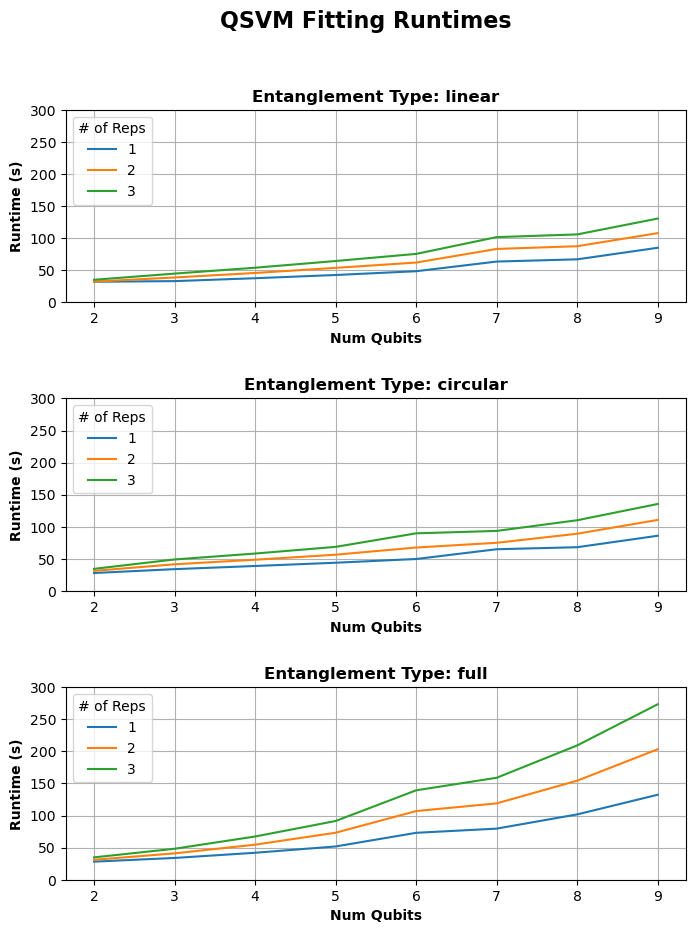

In [48]:
x_label = 'Num Qubits'
y_label = 'Runtime (s)'
title = 'QSVM Fitting Runtimes'
legend_title = '# of Reps'
plot_qsvm_results(qsvm_results, 'num_qubits', 'q_time', reps_range, 'reps',
                  x_label, y_label, title, legend_title, 300, 11)

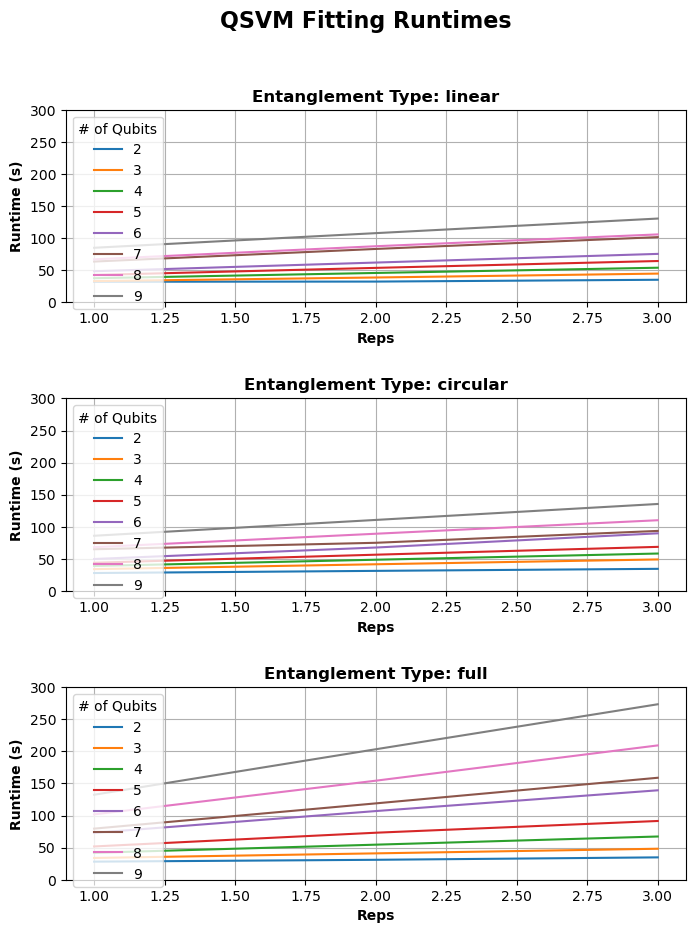

In [49]:
x_label = 'Reps'
y_label = 'Runtime (s)'
title = 'QSVM Fitting Runtimes'
legend_title = '# of Qubits'
plot_qsvm_results(qsvm_results, 'reps', 'q_time', qubits_range, 'num_qubits',
                  x_label, y_label, title, legend_title, 300)

In [50]:
filter_cols = ['num_qubits', 'reps', 'q_time']
linear = qsvm_results[qsvm_results['entanglement_type'] == 'linear'][filter_cols]
circular = qsvm_results[qsvm_results['entanglement_type'] == 'circular'][filter_cols]
full = qsvm_results[qsvm_results['entanglement_type'] == 'full'][filter_cols]

entanglement_times = pd.merge(full, 
                              pd.merge(linear, circular, on=['reps', 'num_qubits'], suffixes=('_linear', '_circular')), 
                              on=['reps', 'num_qubits'],suffixes=('full_', ''))

In [51]:
def count_gates(pattern, n, r):
    if pattern == 'linear':
        return ((n - 1) + n) * r
    elif pattern == 'circular':
        return 2 * n * r
    else:
        return ((n * (n - 1) / 2) + n) * r

qsvm_results['num_gates'] = qsvm_results.apply(
    lambda row: count_gates(row['entanglement_type'], row['num_qubits'], row['reps']),
    axis=1
)


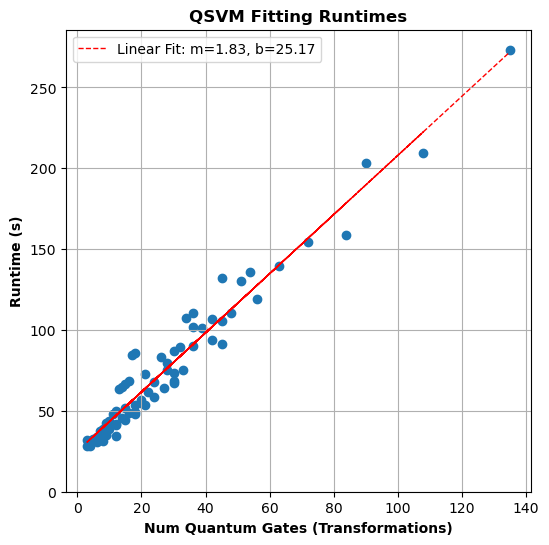

In [52]:
fig_count += 1 
plt.figure(figsize=(figsize_x, figsize_y))

x = qsvm_results['num_gates']
y = qsvm_results['q_time']
m, b = np.polyfit(x, y, 1)  # Linear fit (degree 1)

plt.scatter(qsvm_results['num_gates'], qsvm_results['q_time'])
plt.plot(x, m * x + b, color='red', ls='--', lw=1, label=f'Linear Fit: m={round(m,2)}, b={round(b,2)}')

plt.title('QSVM Fitting Runtimes', fontweight='bold')
plt.xlabel('Num Quantum Gates (Transformations)', fontweight='bold')
plt.ylabel('Runtime (s)', fontweight='bold')
plt.ylim(0)
plt.legend()

plt.grid()
plt.savefig(f'../documents/figures/fig_12.png')
plt.show()

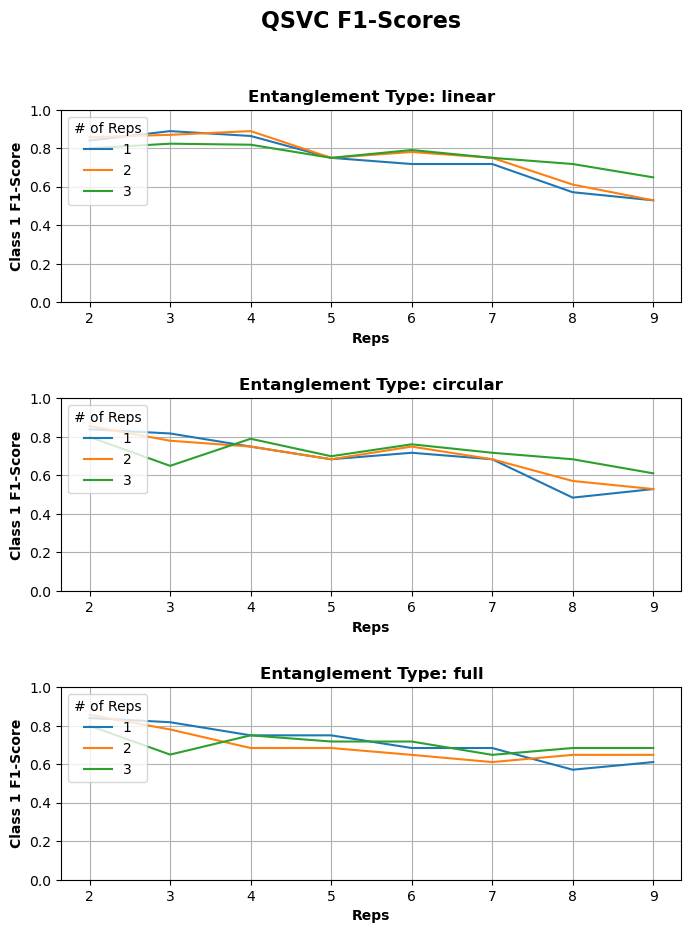

In [53]:
_label = 'Num Qubits'
y_label = 'Class 1 F1-Score'
title = 'QSVC F1-Scores'
legend_title = '# of Reps'
plot_qsvm_results(qsvm_results, 'num_qubits', 'f1_class1', reps_range, 'reps',
                  x_label, y_label, title, legend_title, 1, 13)

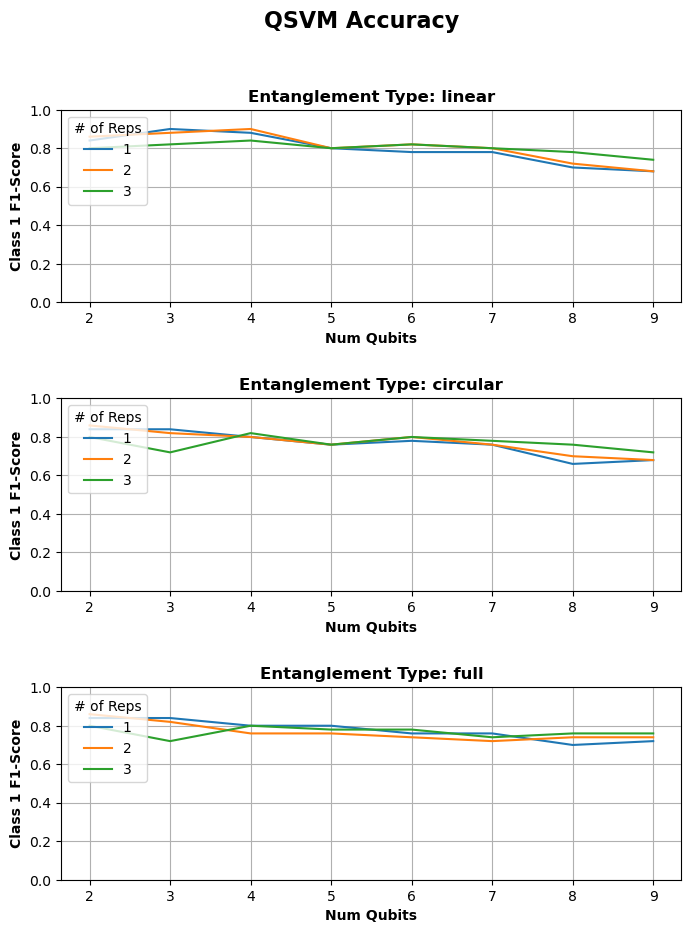

In [54]:
x_label = 'Num Qubits'
y_label = 'Class 1 F1-Score'
title = 'QSVM Accuracy'
legend_title = '# of Reps'
plot_qsvm_results(qsvm_results, 'num_qubits', 'accuracy', reps_range, 'reps',
                  x_label, y_label, title, legend_title, 1)

In [55]:
best_qsvm_circuit = qsvm_results.loc[qsvm_results['f1_class1'].idxmax()]

num_qubits = best_qsvm_circuit['num_qubits']
entanglement = best_qsvm_circuit['entanglement_type']
reps = best_qsvm_circuit['reps']

feature_names = importance_df_svm['variable_name'].values[:num_qubits]
feature_indices = df_X_pp.columns.get_indexer(feature_names)
X_train_tmp = q_X_train[:, feature_indices]
X_test_tmp = q_X_test[:, feature_indices]

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_tmp = scaler.fit_transform(X_train_tmp)
X_test_tmp = scaler.transform(X_test_tmp)

feature_map = ZZFeatureMap(feature_dimension=X_train_tmp.shape[1], reps=reps, entanglement=entanglement)
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler, num_virtual_qubits=X_train_tmp.shape[1])
qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
embeddings = qkernel.evaluate(X_train_tmp, X_train_tmp)
best_qsvm = SVC(class_weight='balanced', random_state=rs)

param_grid = {
    'C': [0.1, 1, 10, 10, 100],
    'gamma': ['scale'],
    'kernel': ['linear', 'rbf']
}

# Perform grid search
scoring_fcn = make_scorer(f1_score, pos_label=1)
grid_search = GridSearchCV(estimator=best_qsvm, param_grid=param_grid, cv=3, scoring=scoring_fcn, verbose=2)
grid_search.fit(embeddings, q_y_train)
best_qsvm = grid_search.best_estimator_

test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
y_pred = best_qsvm.predict(test_embeddings)
print(classification_report(q_y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=scale

## Pegasos QSVC

In [56]:
def fit_pegasos_qsvc(X_train, y_train, reps, C, tau):
    
    feature_map = ZFeatureMap(feature_dimension=q_X_train.shape[1], reps=1)
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    start_time = time.time()
    pegasos_qsvc.fit(q_X_train, y_train) 
    end_time = time.time()
    fit_time = end_time - start_time
    
    return pegasos_qsvc, execution_time

In [57]:
pegasos_qsvc, runtime = fit_pegasos_qsvc(q_X_train, y_train, 1, 1000, 100)

ValueError: 'X' and 'y' have to contain the same number of samples

In [ ]:
def evaluate_pegasos_qsvc(qubits_range, reps_range, C_range, tau_range, importance_df, X_train, X_test, y_train, y_test):

    results = []
    for num_qubits in qubits_range:
            
        feature_names = importance_df['variable_name'].values[:num_qubits]
        feature_indices = df_X_pp.columns.get_indexer(feature_names)
        X_train_tmp = X_train[:, feature_indices]
        X_test_tmp = X_test[:, feature_indices]

        for reps in reps_range:        
            for C in C_range:
                for tau in tau_range:

                    print('Running PegasosQSVC algorithm with the following parameters...')
                    print(f'num_qubits={num_qubits}, reps={reps}, C={C}, tau={tau}')
                
                    pegasos_qsvc, runtime = fit_pegasos_qsvc(X_train_tmp, q_y_train, C, tau) 
                    y_pred =  pegasos_qsvc.predict(X_test_tmp)
                    f1_class1 = f1_score(y_test, y_pred, pos_label=1)
                    f1_class0 = f1_score(y_test, y_pred, pos_label=0)
                    precision_class1 = precision_score(y_test, y_pred, pos_label=1)
                    precision_class0 = precision_score(y_test, y_pred, pos_label=0)
                    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
                    recall_class0 = recall_score(y_test, y_pred, pos_label=0)
                    accuracy = accuracy_score(y_test, y_pred)
        
                    results.append([num_qubits, reps, C, tau, runtime, f1_class1, f1_class0, precision_class1,
                                    precision_class0, recall_class1, recall_class0, accuracy])


    column_names = ['num_quibits', 'reps', 'C', 'tau', 'runtime', 'f1_class1', 'f1_class0', 'precision_class1',
                    'precision_class0', 'recall_class1', 'recall_class0', 'accuracy']
                
    return pd.DataFrame(results, columns=column_names)

## QRF

In [58]:
num_qubits = 2

feature_names = importance_df_rf['variable_name'].values[:num_qubits]
feature_indices = df_X_pp.columns.get_indexer(feature_names)
X_train_tmp = q_X_train[:, feature_indices]
X_test_tmp = q_X_test[:, feature_indices]

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_tmp = scaler.fit_transform(X_train_tmp)
X_test_tmp = scaler.transform(X_test_tmp)

feature_map = ZZFeatureMap(feature_dimension=X_train_tmp.shape[1], reps=1, entanglement='linear')
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler, num_virtual_qubits=X_train_tmp.shape[1])
qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
embeddings = qkernel.evaluate(X_train_tmp, X_train_tmp)
qrf = RandomForestClassifier()
qrf.fit(embeddings, q_y_train)

RandomForestClassifier()

In [59]:
test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
y_pred = qrf.predict(test_embeddings)
print(classification_report(q_y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86        25
         1.0       0.85      0.88      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



In [60]:
def fit_qrf(X_train, y_train, reps, entanglement_type, rs):
    
    feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=reps, entanglement=entanglement_type)
    sampler = StatevectorSampler()
    fidelity = ComputeUncompute(sampler=sampler, num_virtual_qubits=X_train.shape[1])
    qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    
    q_start_time = time.time()
    embeddings = qkernel.evaluate(X_train, X_train)
    q_end_time = time.time()
    q_time = q_end_time - q_start_time

    qrf = RandomForestClassifier(class_weight='balanced', random_state=rs)
    fit_start_time = time.time()
    qrf.fit(embeddings, q_y_train)
    fit_end_time = time.time()
    fit_time = time.time()
        
    return qrf, qkernel, q_time, fit_time

In [61]:
qrf, qkernel, q_time, fit_time = fit_qrf(X_train_tmp, q_y_train, 1, 'linear', rs)
test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
y_pred = qrf.predict(test_embeddings)
print(classification_report(q_y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83        25
         1.0       0.81      0.88      0.85        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



In [62]:
def evaluate_qrf(qubits_range, entanglement_types, reps_range, importance_df, X_train, X_test, y_train, y_test, rs):

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    results = []
    for num_qubits in qubits_range:
            
        feature_names = importance_df['variable_name'].values[:num_qubits]
        feature_indices = df_X_pp.columns.get_indexer(feature_names)
        X_train_tmp = X_train[:, feature_indices]
        X_test_tmp = X_test[:, feature_indices]

        for entanglement_type in entanglement_types:
            for reps in reps_range:

                print('Running QRF algorithm with the following parameters...')
                print(f'num_qubits={num_qubits}, entanglement_type={entanglement_type}, reps={reps}')
                
                start_time = time.time()

                qrf, qkernel, q_time, fit_time = fit_qrf(X_train_tmp, y_train, reps, entanglement_type, rs) 
                test_embeddings = qkernel.evaluate(X_test_tmp, X_train_tmp)
                y_pred = qrf.predict(test_embeddings)

                f1_class1 = f1_score(y_test, y_pred, pos_label=1)
                f1_class0 = f1_score(y_test, y_pred, pos_label=0)
                precision_class1 = precision_score(y_test, y_pred, pos_label=1)
                precision_class0 = precision_score(y_test, y_pred, pos_label=0)
                recall_class1 = recall_score(y_test, y_pred, pos_label=1)
                recall_class0 = recall_score(y_test, y_pred, pos_label=0)
                accuracy = accuracy_score(y_test, y_pred)
    
                results.append([num_qubits, entanglement_type, reps, q_time, fit_time, f1_class1, f1_class0, precision_class1,
                                precision_class0, recall_class1, recall_class0, accuracy])

                end_time = time.time()
                process_time = end_time - start_time
                print(f'Finished after {process_time}s')   

    column_names = ['num_qubits', 'entanglement_type', 'reps', 'q_time', 'fit_time',
                    'f1_class1', 'f1_class0', 'precision_class1', 'precision_class0',
                    'recall_class1', 'recall_class0', 'accuracy']
                
    return pd.DataFrame(results, columns=column_names)

In [64]:
qubits_range = list(range(2,10))
entanglement_types = ['linear', 'circular', 'full']
reps_range = [1,2,3]

# qrf_results = evaluate_qrf(qubits_range, 
#                            entanglement_types, 
#                            reps_range, 
#                            importance_df_rf, 
#                            q_X_train, q_X_test, q_y_train, q_y_test,
#                            rs)

excel_file = '../data/QML_Algorithm_Saved_Results.xlsx'
sheet_name = 'QRF'

# with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
#     qsrf_results.to_excel(writer, sheet_name=sheet_name, index=False)

# qrf_results = pd.read_excel(excel_file, sheet_name=sheet_name)